# Embedding and representation

Lecture 4.

How to represent your problem so that it is easy to solve?

* best coordinate system for circle in a circle?
* PCA
  - component of largest variance
  - digits in 1pixel basis
  - digits in PCA basis
* Autoencoders
  - a NN that learns to reconstruct its input
  - learns a new representation, but we don't have to understand it
  - (denoising?)
* Neural networks learn new representations
  - 1D problem solved by NN
* a simple google reverse image search

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Circle in a circle

What is the best coordinate system to represent this problem?

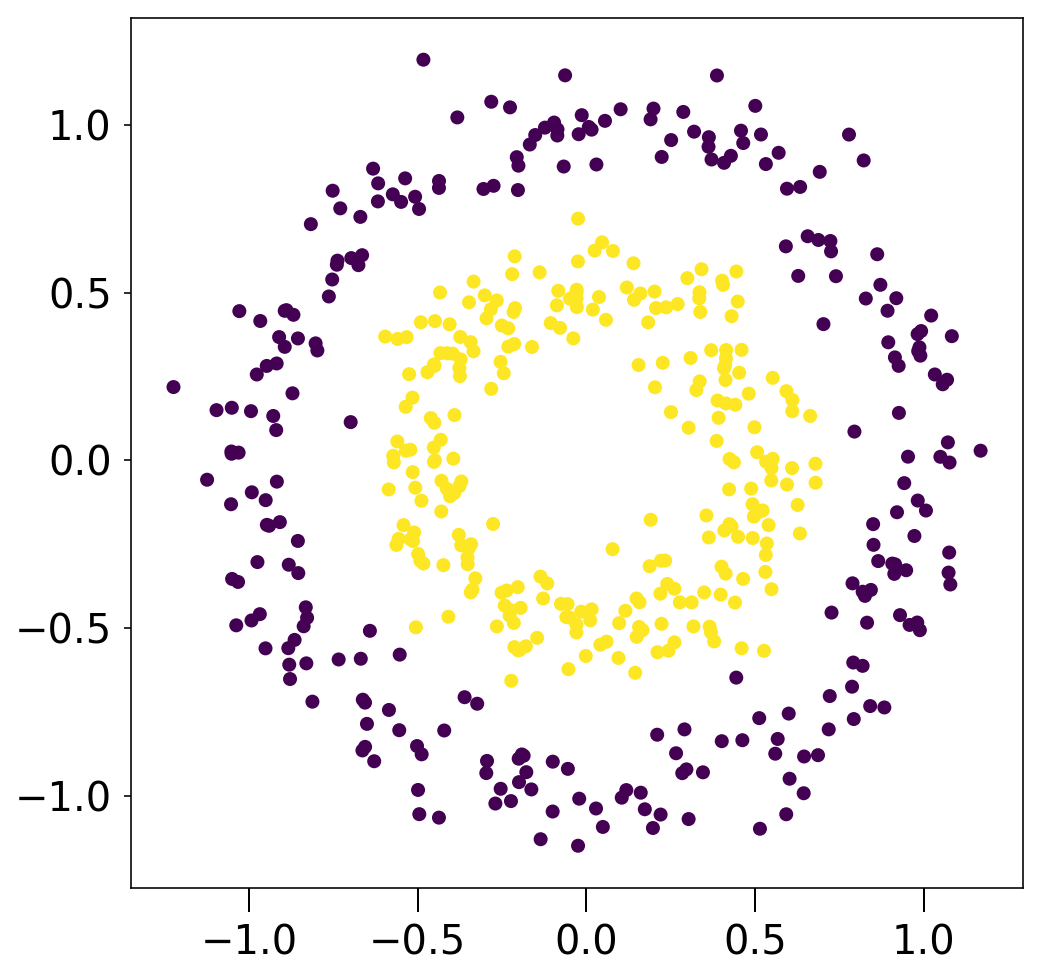

In [2]:
from sklearn.datasets import make_circles

X, y = make_circles(500, factor=0.5, random_state=7, noise=0.1)

plt.scatter(X[:,0], X[:,1], c=y);

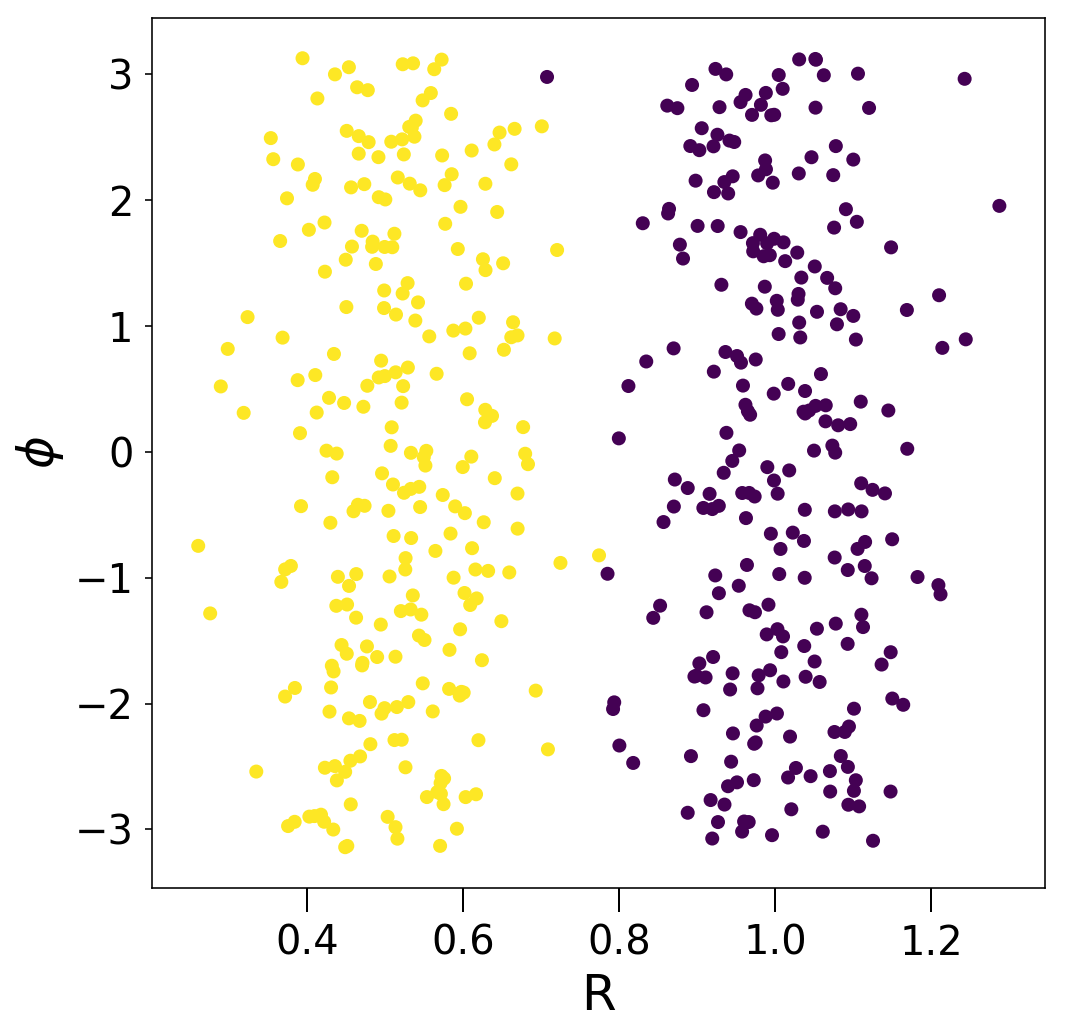

In [3]:
R = np.sqrt(X[:,0]**2 + X[:,1]**2)
phi = np.arctan2(X[:, 1], X[:, 0])

plt.scatter(R, phi, c=y)
plt.ylabel('$\phi$')
plt.xlabel('R');

Using spherical coordinates to represent this problem makes it obvious how to solve it. We found a "better" representation. Today's lecture is all about finding better ways of representing problems.

Why bother doing this?
* visualise high dimensional data (can you see in 50-dimensions?)
* it is what neural networks are doing
* build a search engine by doing nearest neighbour lookup in the new space

## Principle component analysis

Can we automate finding better coordinate systems? Principle component analysis (PCA) is a well known algorithm frequently used for dimensionality reduction. However you can also use it for denoising, feature engineering, etc.

### A five line PCA refresher

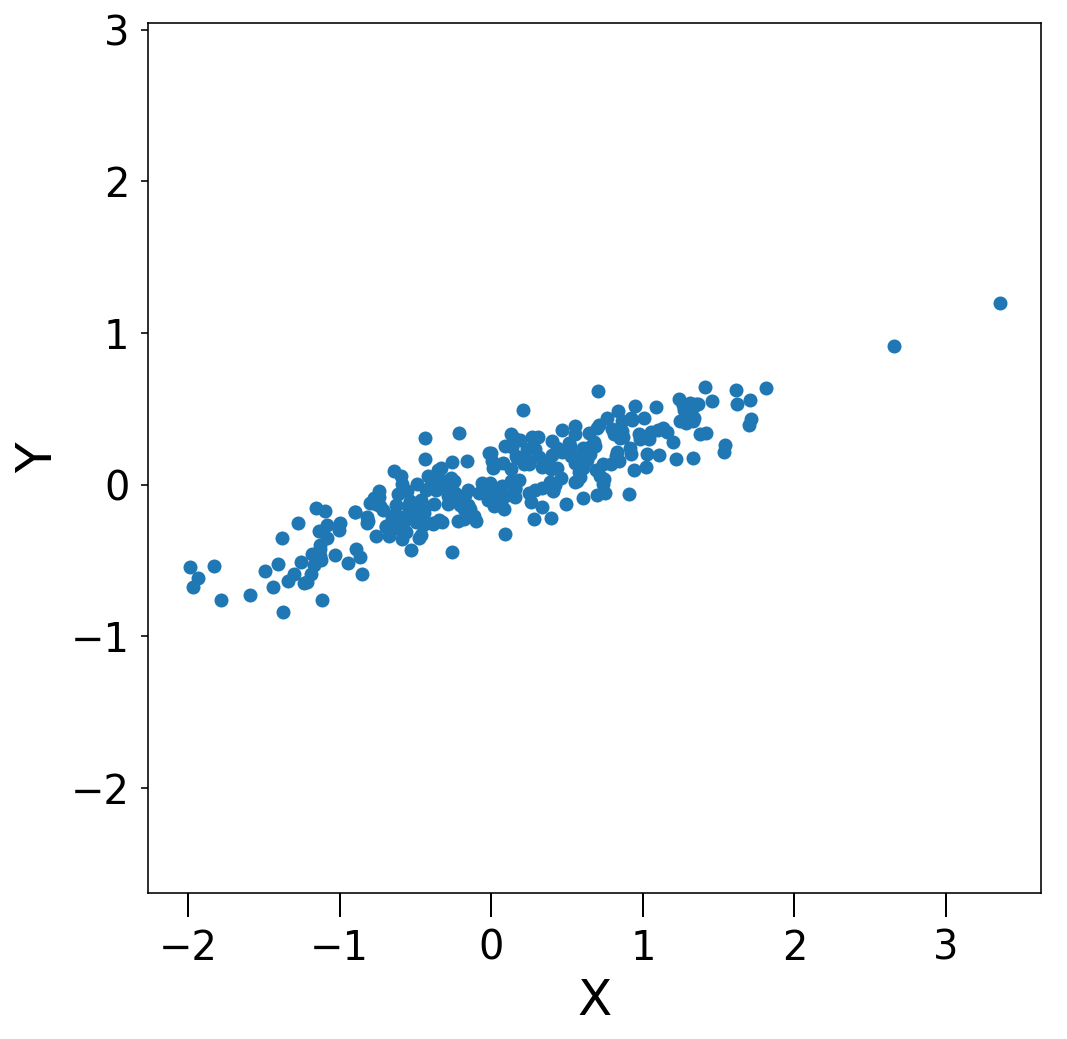

In [4]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 300)).T
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal');

Do we really need both $X$ and $Y$ to represent this data? It looks like there is a linear relationship between the two. Maybe we can rotate the coordinate system.

PCA tries to find a set of axes (or basis vectors) that represent the "principle" axes of the data.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca.components_

array([[ 0.94625072,  0.32343403],
       [-0.32343403,  0.94625072]])

In [7]:
pca.explained_variance_

array([ 0.77675354,  0.01997841])

In [8]:
pca.mean_

array([ 0.06834657,  0.01591613])

PCA finds the axes such that the first axis represents the direction of largest variance of the data. The second axis is the direction of the second largest variance, perpendicular to the first direction. And so on (in higher dimensions).

Let's draw the `components_` as arrows and use the `explained_variance_` to scale the length of the arrows.

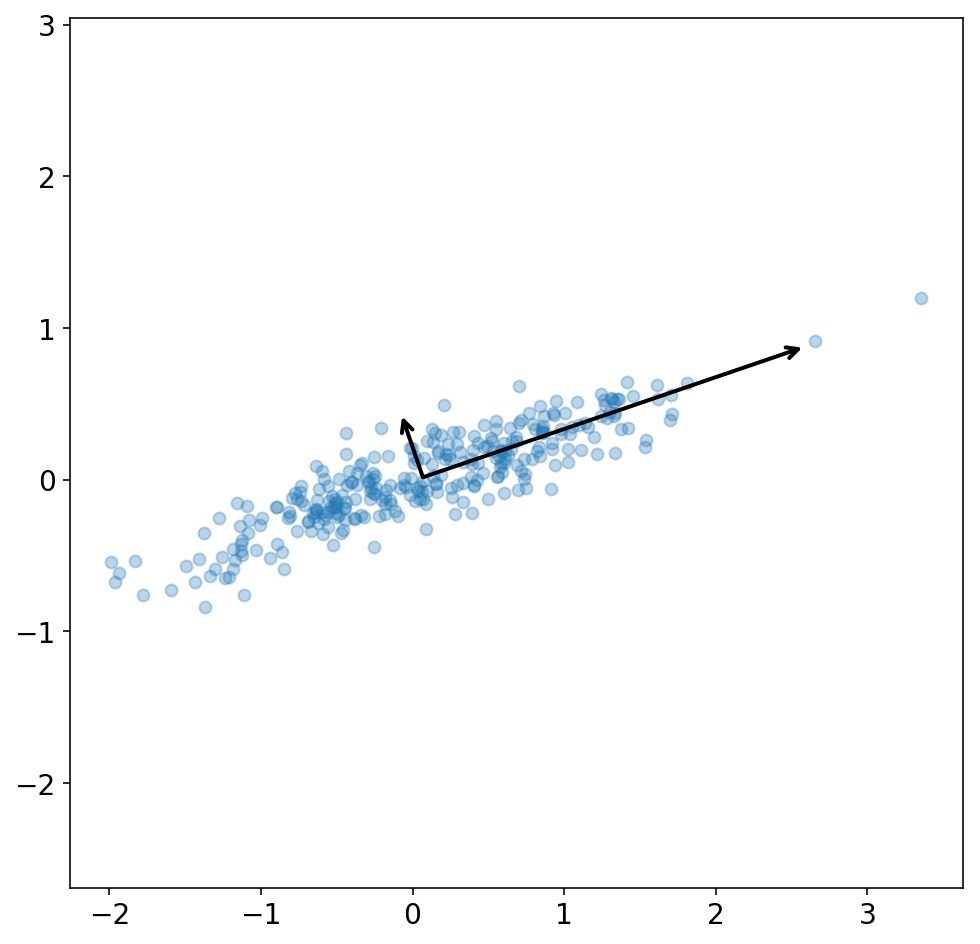

In [8]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

---

## PCA for dimensionality reduction

We can use PCA to reduce the number of dimensions of our data by setting the smallest components to zero.

In [9]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print('shape of transformed data:', X_pca.shape)
print('First five data points after transform:')
print(X_pca[:5])

shape of transformed data: (300, 1)
First five data points after transform:
[[-0.92529032]
 [-1.17957715]
 [ 0.05418085]
 [ 0.28672586]
 [ 0.6291663 ]]


We can "undo" the transformation using `pca.inverse_transform()`, however because we projected the data into a lower dimensional space we remove some information, so we will not recover the original data:

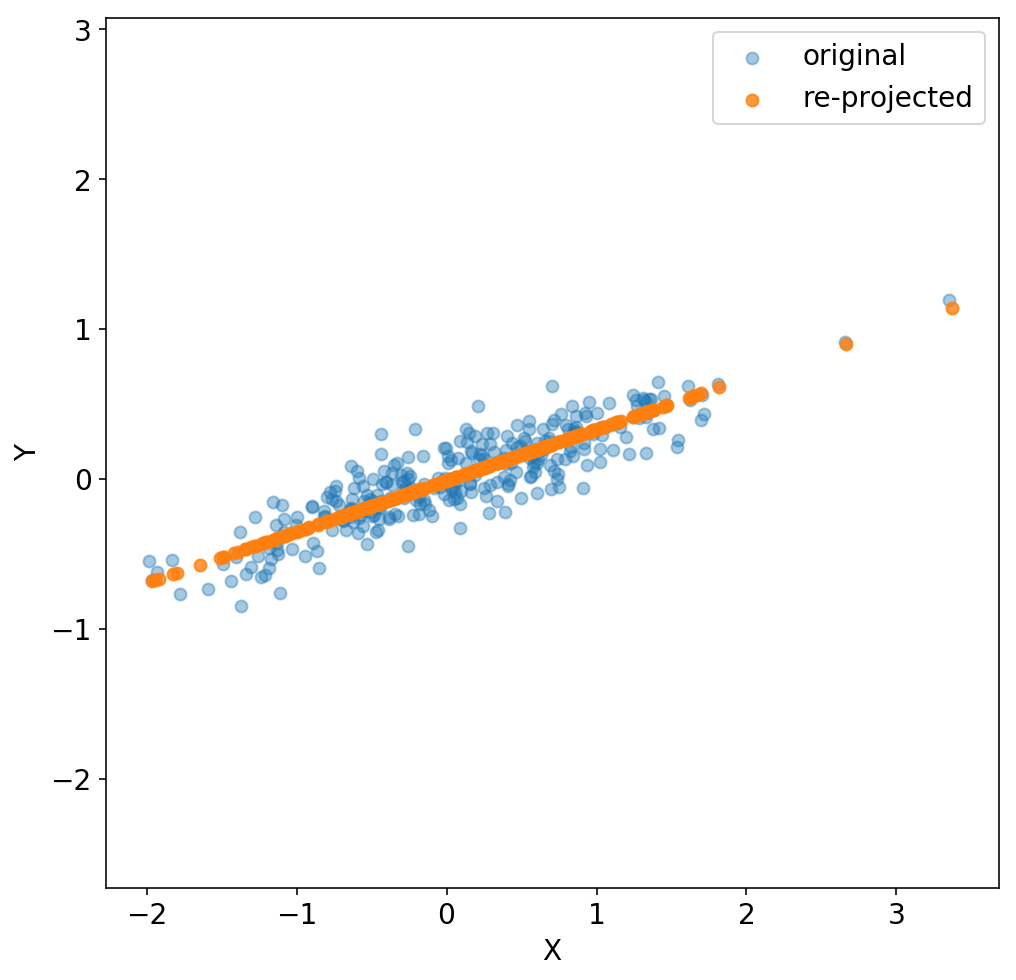

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.4, label='original')
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, label='re-projected')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='best')
plt.axis('equal');

As we suspected: using only one dimension captures a large amount of information about the data already.

Think about this: we reduced by a factor of two the number of dimensions (2->1) but we can still represent most of the relationship between the data points.

---

## The handwritten digits basis vectors

What good is PCA? From a two dimensional toy problem you might not be convinced why this is useful. Let's look at a higher dimensional problem: handwritten digits.

In [11]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

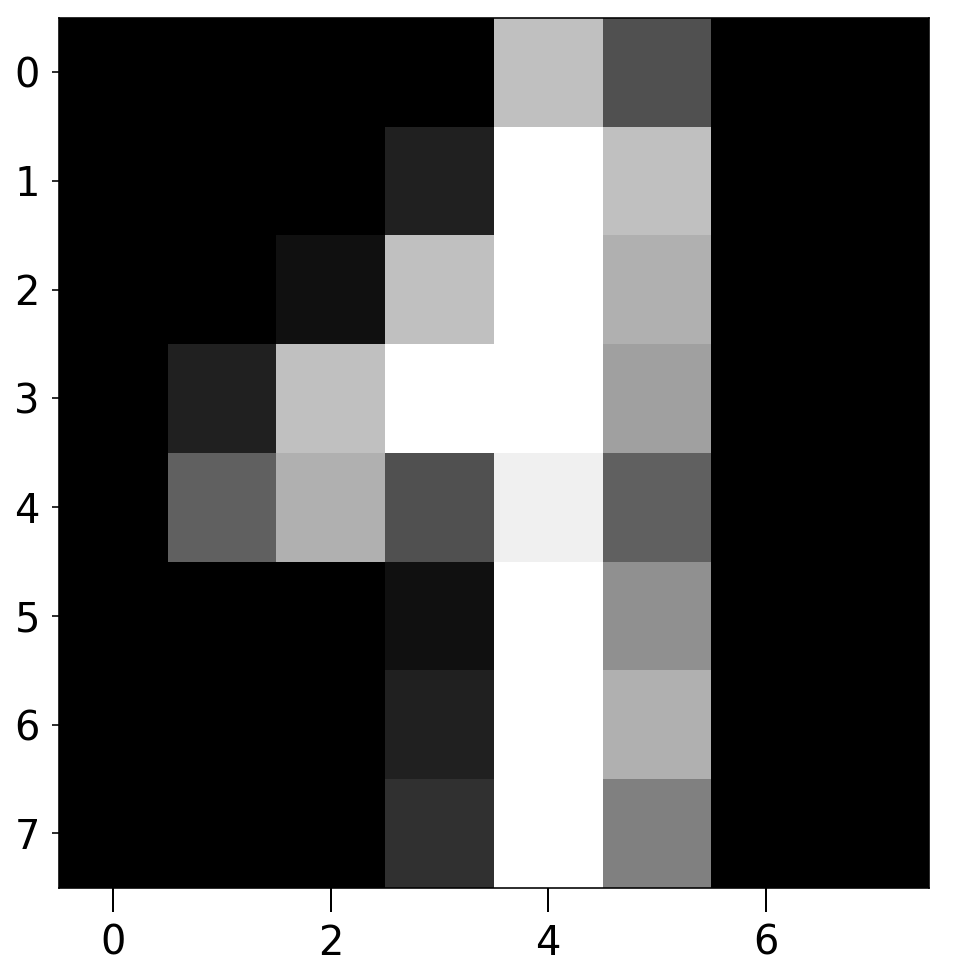

In [12]:
plt.imshow(digits.images[42], cmap='gray');

Each digit is a image with $8\times8$ pixels, so this is a problem that has 64 dimensions. How many dimensions do we need to represent this data really? How can we visualise this high dimensional dataset using only two or three dimensional figures?

#### Simple one-pixel basis vectors

The original representation of the data was in what I will call the "one pixel basis". Each image is represented as 64 numbers which set the intensity of each of the 64 pixels in the image: $x = \left[x_0, x_1, x_2, ... x_{63} \right]$.

In [13]:
def pixel_basis(n):
    """One pixel basis vector `n`"""
    vector = np.zeros(64)
    vector[n] = 255
    return vector.reshape(8, 8)

def show_pixel_basis(n_components=6):
    digit = digits.images[0]
    fig, axs = plt.subplots(1, 3, figsize=(3*4, 4))
    axs[0].imshow(digit, cmap='gray')
    axs[0].set_yticklabels([])
    axs[0].set_xticklabels([])
    axs[0].set_title("complete image")

    sum = np.zeros(64)
    for n in range(n_components):
        sum[n] = digit.ravel()[n]
        ax = axs[1]
        ax.imshow(pixel_basis(n), cmap='gray', vmin=0, vmax=digit.max())
        ax.set_title("intensity %i times:" % digit.ravel()[n])
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    ax = axs[-1]
    ax.set_title("sum of first %i components" % n_components)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(sum.reshape(8,8), cmap='gray', vmin=0, vmax=digit.max())
    plt.show();
    
from ipywidgets import interact

interact(show_pixel_basis, n_components=(1,63));

In [14]:
def show_digit(n_components=6):
    fig, axs = plt.subplots(2, 3, figsize=(12, 2*4))

    for n in range(2):
        digit = digits.data[n]
        ax = axs[n,0]
        ax.set_title('complete image')
        ax.imshow(digit.reshape(8,8), cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        pca = PCA(n_components)
        pca.fit(digits.data)

        # components
        ax = axs[n,1]
        if n_components == 1:
            template = pca.mean_.reshape(8,8)
        else:
            template = pca.components_[n_components-1].reshape(8,8)
        template = pca.components_[n_components-1].reshape(8,8)
        ax.imshow(template, cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax = axs[n,2]
        ax.imshow(pca.inverse_transform(pca.transform(digit.reshape(1, -1))).reshape(8,8), 
                  cmap='gray')
        ax.set_title('mean + first %i components' % (n_components))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()
    
interact(show_digit, n_components=(1,63));

---

### Dimensionality reduction

In [15]:
pca = PCA(2)
projected = pca.fit_transform(digits.data)

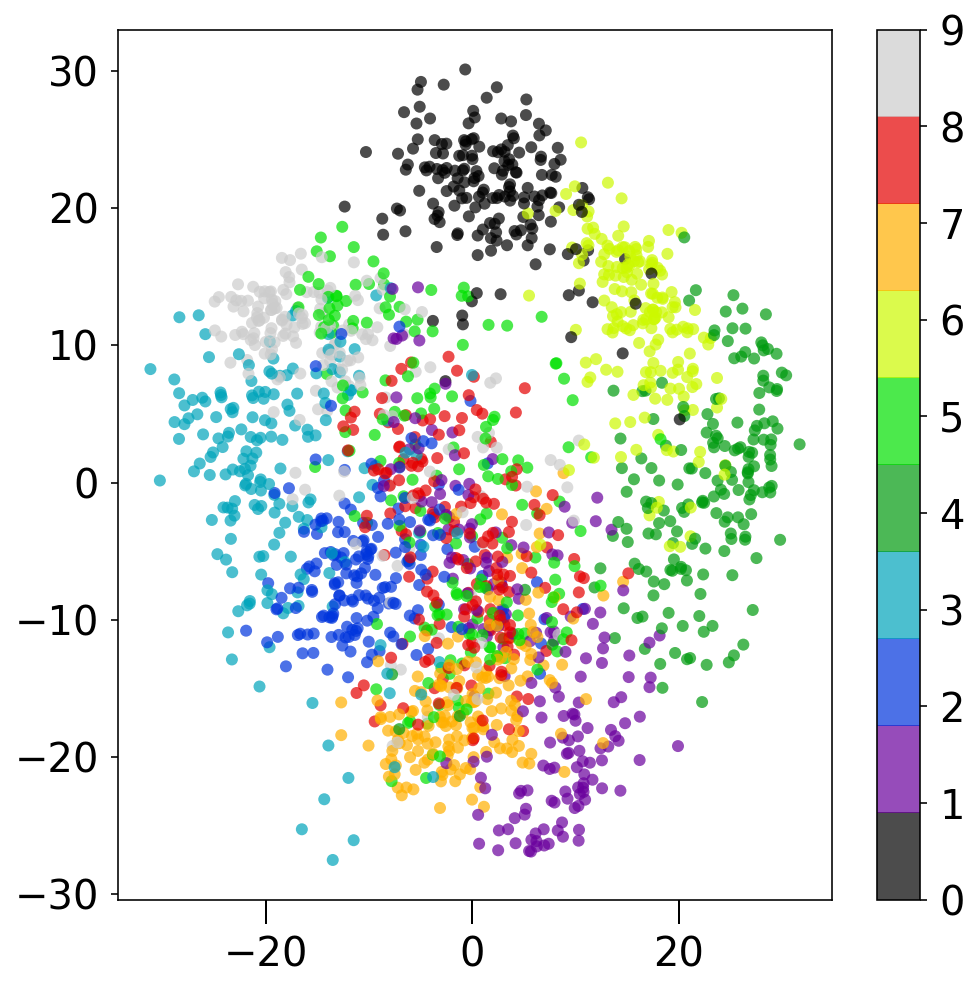

In [16]:
plt.scatter(projected[:,0], projected[:,1], c=digits.target, lw=0,
            alpha=0.7, cmap=plt.cm.get_cmap('spectral', 10))
plt.colorbar();

Each of the points is coloured according to the digit it represents. Each digit from the dataset is placed according to its value for the first two components of the PCA.

This is pretty cool for several reasons:
* we just turned a dataset that has too many dimensions to plot into something that has only two dimensions. Using the labels to colour the points we can check that this is not just a projection to a lower dimensional space but one that groups similar samples (images of similar digits) together in this lower dimensional space
* we did not have to use the labels to get this projection! This is great because most data in the real world does not have labels.

You can think of this a bit like expanding a function as a Fourier series, the more components you add the better the approximation.

Key take away from this: you can represent your data in different ways. Think of each representation as a vector space with (complicated) basis vectors.

---

## Auto encoders

(based on https://blog.keras.io/building-autoencoders-in-keras.html)

<img src="ae.png" width="300px" />

(Image from http://www.asimovinstitute.org/neural-network-zoo/)

Remember last weeks "world's simplest neural network"? We return to the idea of a neural network that learns to reconstruct its input. This is not particularly impressive, unless you create a "bottleneck". If we have a, say, ten dimensional input, force it through a layer that has only five neurons and then use these five neurons to reconstruct the ten dimensional input we have to learn something about the data.

In [17]:
from keras.datasets import mnist

# note: the MNIST dataset has more features and more samples than the digits
# dataset in scikit-learn
# Only load the training images, we don't need more and we do not care for the labels
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28)

X = x_train / 255

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_train,
                                                    train_size=0.8, random_state=1)

Using TensorFlow backend.


This is a very simple Autoencoder. It has one fully connected layer which maps from the 784 inputs (28x28 pixels) to a hidden layer with 32 neurons. It uses ReLu as activation function. From the hidden layer we map back to the output with 784 neurons.

As loss function we use mean squared error.

For realistic problems you can use more complicated network architectures. You do not have to use just one layer. For exampe you can use several layers of `conv-relu-pool` as the encoder and then mirror that with deconvolution layers on the decoding side.

(Note: you will often find that people used to share the weights between the decoder and encoder. We didn't do this here...)

In [18]:
from keras.layers import Input, Dense
from keras.models import Model

# go from 784 dimensions to 32, a reduction of factor 24
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='relu')(encoded)

autoencoder = Model(input_img, decoded)

In [19]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, X_test))

In [20]:
print('final valdiation loss (MSE):', model.history['val_loss'][-1])

final valdiation loss (MSE): 0.0138670224349


In [21]:
# shortcut to perform just the encoding
encoder = Model(input_img, encoded)

# shortcut to perform just the decoding step
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

X_encoded = encoder.predict(X_test)
X_decoded = decoder.predict(X_encoded)

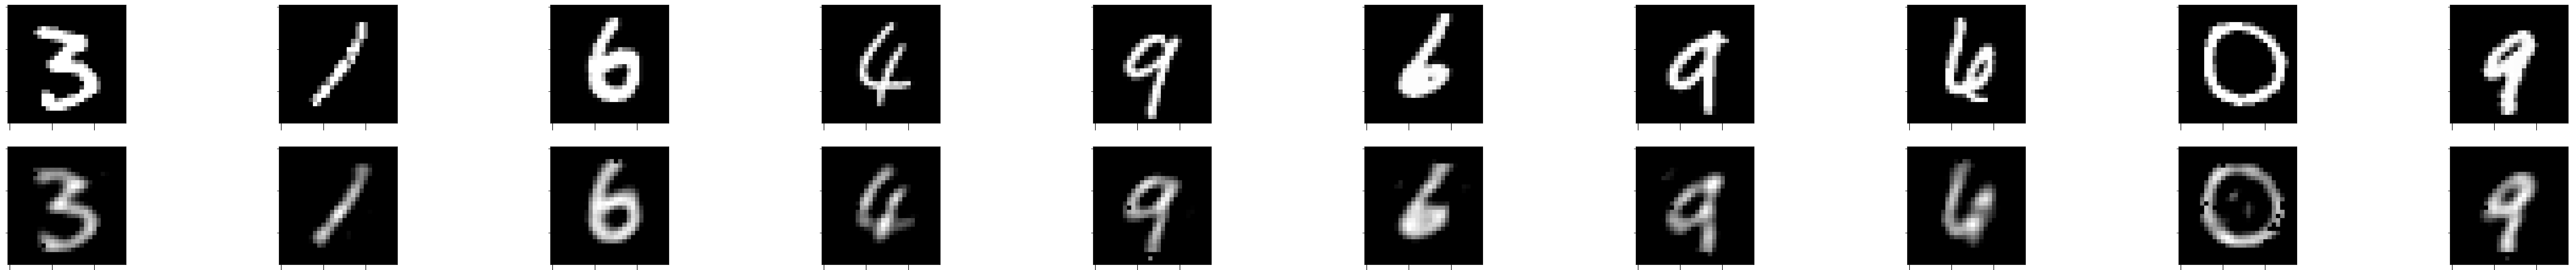

In [22]:
n_images = 10
fig, axs = plt.subplots(2, 10, figsize=(n_images * 8, 8))
for i in range(n_images):
    # original
    ax = axs[0, i]
    ax.imshow(X_test[i+42].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # reconstruction
    ax = axs[1, i]
    ax.imshow(X_decoded[i+42].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

What do autoencoders have to do with finding better representations?

Setup like this autoencoders learn something similar to what you get from PCA. If you setup the size of the hidden layer (also called latent space) to be two then you can produce nice pictures where you step through all possible values in this 2D space and look at the output generated for that point. What you discover is that the digits tend to group together, like in PCA. A good read with pictures is http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html though they setup their autoencoder slightly differently.

As we force the input through a constriction or bottleneck of only 32 neurons, the network has to be learning something about the structure of the data we are feeding it. This means you can think of the hidden layer as a better representation of the data.

When interest in deep learning took off again the first ideas were to use autoencoders to pre-train parts of your deep network. Then take off the output layer, freeze the weights, and stack another autoencoder on top. Train that autoencoder, repeat.

This lead to "deep boltzman machines". Today this is not used anymore, networks are simply trained using labelled data and back-propagation.

The idea was/is attractive because it does not require labelled data! There is a lot of labelled data out there in the world but there is far more unlabelled data available.

The take away from this is that neural networks spend most of their time transforming your data into a better representation. Ideally you keep transforming your very complicated data until it is linearly separable. Why? Because the final layer of a neural network is "just" a linear classifier.

If they learn such good representations ... why don't we use them?